# Methods to Handle Class Imbalance

References:

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10845793

In [2]:
import sys
sys.path.append("../src")   # relative to notebooks/

import pandas as pd
from config import TARGET_COL, TEST_DATA_PATH, TRAIN_DATA_PATH
from preprocessing import load_and_preprocess_data

Scale data before SMOTE
- SMOTE relies on distance calculations (e.g. kNN) to create new synthetic samples

Create new samples based on train data
- Since SMOTE creates new samples which are interpolations of the dataset used, SMOTE should be performed after train test split to avoid data leakage

In [3]:
X_train, X_test, y_train, y_test, preprocessor = load_and_preprocess_data(
    str(TRAIN_DATA_PATH),
    str(TEST_DATA_PATH),
    target_col=TARGET_COL
)

Train shape: (120889, 55)
Test shape: (30223, 55)

Preprocessing features...
Processed train shape: (120889, 58)
Processed test shape: (30223, 58)
Number of features: 58


# Oversampling
## 1. Handling Class Imbalance with SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [4]:
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

In [5]:
positive_cases = resampled_df[resampled_df["class"] == 1].shape[0]
negative_cases = fraud_cases = resampled_df[resampled_df["class"] == 0].shape[0]

print(f"Imbalance Ratio = {positive_cases/negative_cases}")

Imbalance Ratio = 1.0


In [60]:
from models import FraudDetectionModel
from evaluation import ModelEvaluator


def train_evaluate(X_train, y_train, X_test, y_test, model_type="logistic_regression", custom_params=None):
    model = FraudDetectionModel(model_type=model_type, custom_params=custom_params)
    model.fit(X_train, y_train)

    print(model.get_feature_importance(top_n=10))

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    evaluation = ModelEvaluator(model_name=model_type)
    evaluation.evaluate(y_true=y_test, y_pred=y_pred, y_proba=y_proba)


### Train Logistic Regression Model with Resampled Data

In [7]:
train_evaluate(X_resampled, y_resampled, X_test, y_test)

                           feature  coefficient
47                       age_26_35     0.727301
48                       age_36_50     0.681726
46                       age_18_25     0.659886
7          txn_count_ip_percentile     0.531945
6      txn_count_device_percentile     0.443783
14  time_since_last_ip_address_txn    -0.367151
19                is_unique_device    -0.193290
20                    is_unique_ip    -0.135682
29             fraud_rate_by_month     0.041971
17              purchase_std_by_ip    -0.037737

logistic_regression Evaluation Results
Accuracy:  0.9520
Precision: 0.9248
Recall:    0.5304
F1 Score:  0.6742
ROC-AUC:   0.7723
PR-AUC:    0.6037

              precision    recall  f1-score   support

           0     0.9535    0.9955    0.9741     27393
           1     0.9248    0.5304    0.6742      2830

    accuracy                         0.9520     30223
   macro avg     0.9392    0.7630    0.8241     30223
weighted avg     0.9508    0.9520    0.9460     302

### Train Random Forest with Resampled Data

In [13]:
train_evaluate(X_resampled, y_resampled, X_test, y_test, model_type="random_forest")

                        feature  importance
19             is_unique_device    0.113321
6   txn_count_device_percentile    0.088518
4       txn_count_device_zscore    0.080485
15       purchase_std_by_device    0.061705
12    time_setup_to_txn_seconds    0.054851
2           txn_count_by_device    0.054644
5           txn_count_ip_zscore    0.047056
20                 is_unique_ip    0.043057
21        purchase_cv_by_device    0.032361
29          fraud_rate_by_month    0.028160

random_forest Evaluation Results
Accuracy:  0.9549
Precision: 0.9823
Recall:    0.5283
F1 Score:  0.6870
ROC-AUC:   0.7735
PR-AUC:    0.6282

              precision    recall  f1-score   support

           0     0.9535    0.9990    0.9757     27393
           1     0.9823    0.5283    0.6870      2830

    accuracy                         0.9549     30223
   macro avg     0.9679    0.7636    0.8314     30223
weighted avg     0.9562    0.9549    0.9487     30223



### Train XGBoost with Resampling

In [14]:
train_evaluate(X_resampled, y_resampled, X_test, y_test, model_type="xgboost")

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [09:18:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                feature  importance
2   txn_count_by_device    0.583064
41      browser_FireFox    0.043357
44       browser_Safari    0.038492
29  fraud_rate_by_month    0.036071
40       browser_Chrome    0.035150
39           source_SEO    0.027749
30                  gdp    0.022360
37           source_Ads    0.021243
43        browser_Opera    0.017884
28            month_cos    0.017067

xgboost Evaluation Results
Accuracy:  0.0943
Precision: 0.0937
Recall:    1.0000
F1 Score:  0.1713
ROC-AUC:   0.7674
PR-AUC:    0.6231

              precision    recall  f1-score   support

           0     1.0000    0.0007    0.0015     27393
           1     0.0937    1.0000    0.1713      2830

    accuracy                         0.0943     30223
   macro avg     0.5468    0.5004    0.0864     30223
weighted avg     0.9151    0.0943    0.0174     30223



### Investigate results of xgboost further as there seems to be overfitting / prediction that every instance is fraudulent

<Axes: >

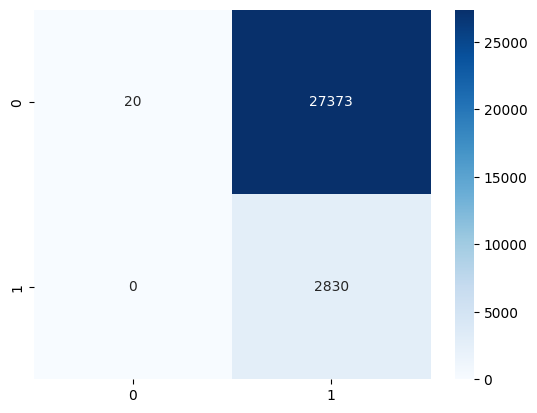

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_pred=y_pred_xgb, y_true=y_test), annot=True, fmt="d", cmap="Blues")

# Undersampling
## 2. Handling Class Imbalance with Random Undersampling
- Since the dataset is large, undersampling may be advantageous due to enhanced computational efficiency and reduced redundancy

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=False)
X_rus_train, y_rus_train = rus.fit_resample(X_train, y_train)

In [16]:
lr_rus = FraudDetectionModel(model_type="logistic_regression")

# Fit Logistic Regression model with resampled data
lr_rus.fit(X_rus_train, y_rus_train)

In [17]:
lr_feature_importance = lr_rus.feature_importance_
lr_feature_importance[lr_feature_importance["coefficient"] != 0]

,feature,coefficient
6,txn_count_device_percentile,0.558882
7,txn_count_ip_percentile,0.373688
17,purchase_std_by_ip,-0.054126
20,is_unique_ip,-0.030901
29,fraud_rate_by_month,0.019804


In [18]:
y_pred = lr_rus.predict(X_test)
y_proba = lr_rus.predict_proba(X_test)[:, 1]

lr_evaluation = ModelEvaluator(model_name="logistic_regression")
lr_evaluation.evaluate(y_true=y_test, y_pred=y_pred, y_proba=y_proba)


logistic_regression Evaluation Results
Accuracy:  0.9503
Precision: 0.8952
Recall:    0.5311
F1 Score:  0.6667
ROC-AUC:   0.7631
PR-AUC:    0.5954

              precision    recall  f1-score   support

           0     0.9535    0.9936    0.9731     27393
           1     0.8952    0.5311    0.6667      2830

    accuracy                         0.9503     30223
   macro avg     0.9243    0.7623    0.8199     30223
weighted avg     0.9480    0.9503    0.9444     30223



{'accuracy': 0.9502696621778116,
 'precision': 0.8951756998213222,
 'recall': 0.5310954063604241,
 'f1': 0.6666666666666666,
 'roc_auc': 0.763061286065319,
 'pr_auc': 0.5954304267557731}

## Handling Class Imbalance with Edited Nearest Neighbours

In [16]:
from imblearn.under_sampling import EditedNearestNeighbours

def enn_resample(X_train, y_train, n_neighbors):
    enn = EditedNearestNeighbours(n_neighbors=n_neighbors)
    X_enn, y_enn = enn.fit_resample(X_train, y_train)
    return X_enn, y_enn

X_enn_9, y_enn_9 = enn_resample(X_train, y_train, 9)
X_enn_5, y_enn_5 = enn_resample(X_train, y_train, 5)
X_enn_3, y_enn_3 = enn_resample(X_train, y_train, 3)

In [23]:
train_evaluate(
    X_train=X_enn_5,
    y_train=y_enn_5,
    X_test=X_test,
    y_test=y_test,
    model_type="logistic_regression"
)

                           feature  coefficient
6      txn_count_device_percentile     1.029282
14  time_since_last_ip_address_txn    -0.276094
17              purchase_std_by_ip    -0.256414
29             fraud_rate_by_month     0.066399
7          txn_count_ip_percentile     0.063542
20                    is_unique_ip    -0.009105
15          purchase_std_by_device    -0.001865
39                      source_SEO     0.000000
31                        gdp_rank     0.000000
32             gdp_rank_normalized     0.000000

logistic_regression Evaluation Results
Accuracy:  0.9515
Precision: 0.9153
Recall:    0.5311
F1 Score:  0.6722
ROC-AUC:   0.7635
PR-AUC:    0.6014

              precision    recall  f1-score   support

           0     0.9536    0.9949    0.9738     27393
           1     0.9153    0.5311    0.6722      2830

    accuracy                         0.9515     30223
   macro avg     0.9345    0.7630    0.8230     30223
weighted avg     0.9500    0.9515    0.9456     302

In [21]:
train_evaluate(
    X_train=X_enn_9,
    y_train=y_enn_9,
    X_test=X_test,
    y_test=y_test,
    model_type="xgboost"
)

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [09:19:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                           feature  importance
2              txn_count_by_device    0.960685
14  time_since_last_ip_address_txn    0.011583
29             fraud_rate_by_month    0.001902
43                   browser_Opera    0.001698
36                       cluster_8    0.001604
12       time_setup_to_txn_seconds    0.001576
30                             gdp    0.001433
41                 browser_FireFox    0.001425
0                   purchase_value    0.001375
1                transaction_month    0.001366

xgboost Evaluation Results
Accuracy:  0.1056
Precision: 0.0942
Recall:    0.9922
F1 Score:  0.1720
ROC-AUC:   0.7628
PR-AUC:    0.6221

              precision    recall  f1-score   support

           0     0.9458    0.0140    0.0276     27393
           1     0.0942    0.9922    0.1720      2830

    accuracy                         0.1056     30223
   macro avg     0.5200    0.5031    0.0998     30223
weighted avg     0.8661    0.1056    0.0411     30223



In [22]:
train_evaluate(
    X_train=X_enn_5,
    y_train=y_enn_5,
    X_test=X_test,
    y_test=y_test,
    model_type="xgboost"
)

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [09:20:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                           feature  importance
2              txn_count_by_device    0.930475
14  time_since_last_ip_address_txn    0.021906
8            device_ip_consistency    0.007052
12       time_setup_to_txn_seconds    0.003586
29             fraud_rate_by_month    0.002749
41                 browser_FireFox    0.002291
39                      source_SEO    0.002087
1                transaction_month    0.002073
28                       month_cos    0.002056
36                       cluster_8    0.001993

xgboost Evaluation Results
Accuracy:  0.1210
Precision: 0.0950
Recall:    0.9837
F1 Score:  0.1733
ROC-AUC:   0.7636
PR-AUC:    0.6213

              precision    recall  f1-score   support

           0     0.9500    0.0319    0.0617     27393
           1     0.0950    0.9837    0.1733      2830

    accuracy                         0.1210     30223
   macro avg     0.5225    0.5078    0.1175     30223
weighted avg     0.8699    0.1210    0.0722     30223



In [30]:
train_evaluate(
    X_train=X_enn_3,
    y_train=y_enn_3,
    X_test=X_test,
    y_test=y_test,
    model_type="xgboost"
)

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:24:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                      feature  importance
2         txn_count_by_device    0.967203
8       device_ip_consistency    0.007250
12  time_setup_to_txn_seconds    0.003654
38              source_Direct    0.001412
39                 source_SEO    0.001368
41            browser_FireFox    0.001349
43              browser_Opera    0.001339
27                  month_sin    0.001298
44             browser_Safari    0.001273
29        fraud_rate_by_month    0.001266

xgboost Evaluation Results
Accuracy:  0.1614
Precision: 0.0952
Recall:    0.9353
F1 Score:  0.1728
ROC-AUC:   0.7314
PR-AUC:    0.5838

              precision    recall  f1-score   support

           0     0.9242    0.0814    0.1497     27393
           1     0.0952    0.9353    0.1728      2830

    accuracy                         0.1614     30223
   macro avg     0.5097    0.5084    0.1612     30223
weighted avg     0.8466    0.1614    0.1519     30223



## 3. Hybrid Class Imbalancing Methods

Before applying hybrid class imbalancing methods, understand structure and overlap of fraudulent and non-fradulent transactions

Original class distribution: Counter({0: 136961, 1: 14151})


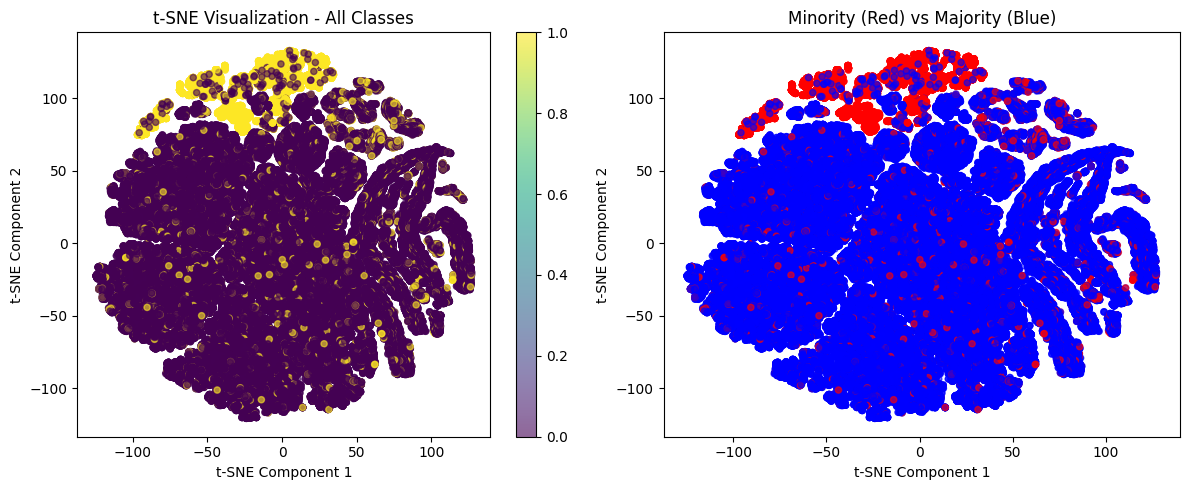

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# Assuming you have X (features) and y (labels)
print("Original class distribution:", Counter(y))

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Visualize
plt.figure(figsize=(12, 5))

# Plot 1: All classes
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', 
                     alpha=0.6, s=20)
plt.colorbar(scatter)
plt.title('t-SNE Visualization - All Classes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot 2: Highlight minority vs majority
plt.subplot(1, 2, 2)
majority_class = Counter(y).most_common(1)[0][0]
colors = ['red' if label != majority_class else 'blue' for label in y]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, s=20)
plt.title('Minority (Red) vs Majority (Blue)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

According to https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10845793, SMOTE-Tomek and SMOTE-ENN may not perform optimally where there is a high overlapping in the dataset.

As SMOTE creates syntetic samples that are interpolations between minority samples, it would mean that apart from landing in "clean" regions, some synthetic samples may land in overlappping regions near the majority class or noisy regions, both of which are problematic. 

In [17]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(
    smote=SMOTE(k_neighbors=5, sampling_strategy="auto"),
    enn=EditedNearestNeighbours(n_neighbors=3, kind_sel='all')
)

X_se, y_se = smote_enn.fit_resample(X_train, y_train)

print(f"Class imbalance ratio: {round((len(y_se) - sum(y_se))/sum(y_se),2)}")

NameError: name 'SMOTE' is not defined

### Train Logistic Regression with SMOTE-ENN resampling

In [49]:
train_evaluate(
    X_train=X_se,
    y_train=y_se,
    X_test=X_test,
    y_test=y_test,
    model_type="logistic_regression"
)

                           feature  coefficient
47                       age_26_35     0.637414
48                       age_36_50     0.618918
46                       age_18_25     0.608806
7          txn_count_ip_percentile     0.441823
19                is_unique_device    -0.407109
14  time_since_last_ip_address_txn    -0.323349
6      txn_count_device_percentile     0.277179
17              purchase_std_by_ip    -0.254694
29             fraud_rate_by_month     0.054504
15          purchase_std_by_device    -0.011757

logistic_regression Evaluation Results
Accuracy:  0.9516
Precision: 0.9181
Recall:    0.5307
F1 Score:  0.6726
ROC-AUC:   0.7702
PR-AUC:    0.6052

              precision    recall  f1-score   support

           0     0.9535    0.9951    0.9739     27393
           1     0.9181    0.5307    0.6726      2830

    accuracy                         0.9516     30223
   macro avg     0.9358    0.7629    0.8233     30223
weighted avg     0.9502    0.9516    0.9457     302

In [25]:
train_evaluate(
    X_train=X_se,
    y_train=y_se,
    X_test=X_test,
    y_test=y_test,
    model_type="random_forest"
)

                        feature  importance
19             is_unique_device    0.135372
4       txn_count_device_zscore    0.083153
2           txn_count_by_device    0.067830
6   txn_count_device_percentile    0.064482
15       purchase_std_by_device    0.058177
12    time_setup_to_txn_seconds    0.055667
22            purchase_cv_by_ip    0.039628
20                 is_unique_ip    0.037660
5           txn_count_ip_zscore    0.035927
21        purchase_cv_by_device    0.034049

random_forest Evaluation Results
Accuracy:  0.9544
Precision: 0.9642
Recall:    0.5325
F1 Score:  0.6861
ROC-AUC:   0.7899
PR-AUC:    0.6476

              precision    recall  f1-score   support

           0     0.9538    0.9980    0.9754     27393
           1     0.9642    0.5325    0.6861      2830

    accuracy                         0.9544     30223
   macro avg     0.9590    0.7652    0.8307     30223
weighted avg     0.9548    0.9544    0.9483     30223



In [26]:
train_evaluate(
    X_train=X_se,
    y_train=y_se,
    X_test=X_test,
    y_test=y_test,
    model_type="xgboost"
)

/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:23:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                feature  importance
2   txn_count_by_device    0.540141
44       browser_Safari    0.065013
41      browser_FireFox    0.036640
28            month_cos    0.035801
39           source_SEO    0.031378
29  fraud_rate_by_month    0.029172
30                  gdp    0.026425
32  gdp_rank_normalized    0.025310
42           browser_IE    0.024739
40       browser_Chrome    0.022183

xgboost Evaluation Results
Accuracy:  0.0944
Precision: 0.0937
Recall:    1.0000
F1 Score:  0.1714
ROC-AUC:   0.7457
PR-AUC:    0.5884

              precision    recall  f1-score   support

           0     1.0000    0.0008    0.0017     27393
           1     0.0937    1.0000    0.1714      2830

    accuracy                         0.0944     30223
   macro avg     0.5469    0.5004    0.0865     30223
weighted avg     0.9151    0.0944    0.0176     30223



After exploring some resampling methods, SMOTE seems to make the most sense based on the data we have. 

Also, there seems to be overfitting in xgboost as one feature is significantly similar to the others

future works
- tomek links
- GANs

# Post Modelling EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
processed_train_df = pd.concat([X_train, y_train], axis=1)

## Effect of Age
- age group features, specifically `age_26_35`, `age_36_50` and `age_18_25`, are important in Logistic Regression, but not in the other models

<Axes: xlabel='class', ylabel='age'>

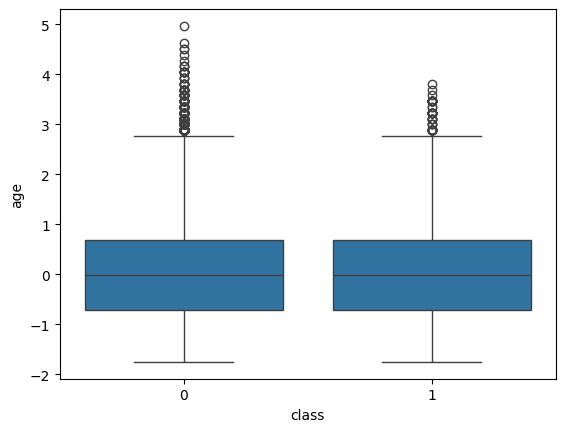

In [9]:
# original distribution of age
sns.boxplot(y=processed_train_df["age"], x=processed_train_df["class"])

In [10]:
# Age group distribution
age_cols = [col for col in processed_train_df if col.startswith("age_") and col != "age_group"]

dist = processed_train_df.groupby('class')[age_cols].sum().T
dist_pct = dist.div(dist.sum(axis=1), axis=0)

age_counts = pd.concat([dist, dist_pct], axis=1)
age_counts

class,0,1,0,1
age_group_18_25,21033.0,2073.0,0.910283,0.089717
age_group_26_35,45543.0,4676.0,0.906888,0.093112
age_group_36_50,37599.0,3961.0,0.904692,0.095308
age_group_51_65,3401.0,390.0,0.897125,0.102875
age_group_over_65,28.0,1.0,0.965517,0.034483
age_group_under_18,1964.0,220.0,0.899267,0.100733
age_under_18,1964.0,220.0,0.899267,0.100733
age_18_25,21033.0,2073.0,0.910283,0.089717
age_26_35,45543.0,4676.0,0.906888,0.093112
age_36_50,37599.0,3961.0,0.904692,0.095308


While transactions by those over 65 are less likely to be fraudulent, those over 65 constitute a very small proportion of the whole dataset, and the remaining age groups have consistent proportion of fraudulent to non-fraudulent transactions, so age may not be necessary

In [12]:
# drop age columns to see how Logistic Regression Model performs with smote-enn
cols = [col for col in X_train.columns if not col.startswith("age_")]

X_train_age_filtered = X_train[cols]
X_test_age_filtered = X_test[cols]

In [21]:
X_age_filtered_se, y_age_filtered_se = SMOTEENN(
    smote=SMOTE(k_neighbors=5, sampling_strategy="auto"),
    enn=EditedNearestNeighbours(n_neighbors=3, kind_sel='all')
).fit_resample(X_train_age_filtered, y_train)

train_evaluate(
    X_train=X_age_filtered_se,
    y_train=y_age_filtered_se,
    X_test=X_test_age_filtered,
    y_test=y_test,
    model_type="logistic_regression"
)

                           feature  coefficient
7      txn_count_device_percentile     0.529352
21                    is_unique_ip    -0.520629
15  time_since_last_ip_address_txn    -0.352652
20                is_unique_device    -0.197742
18              purchase_std_by_ip    -0.115528
30             fraud_rate_by_month     0.064132
40                      source_SEO    -0.041997
36                       cluster_5     0.007628
16          purchase_std_by_device    -0.004249
0                   purchase_value     0.000000

logistic_regression Evaluation Results
Accuracy:  0.9520
Precision: 0.9248
Recall:    0.5304
F1 Score:  0.6742
ROC-AUC:   0.7669
PR-AUC:    0.6036

              precision    recall  f1-score   support

           0     0.9535    0.9955    0.9741     27393
           1     0.9248    0.5304    0.6742      2830

    accuracy                         0.9520     30223
   macro avg     0.9392    0.7630    0.8241     30223
weighted avg     0.9508    0.9520    0.9460     302

In [22]:
train_evaluate(
    X_train=X_age_filtered_se,
    y_train=y_age_filtered_se,
    X_test=X_test_age_filtered,
    y_test=y_test,
    model_type="random_forest"
)

                        feature  importance
5       txn_count_device_zscore    0.086412
3           txn_count_by_device    0.086124
7   txn_count_device_percentile    0.078682
16       purchase_std_by_device    0.075479
13    time_setup_to_txn_seconds    0.062950
4               txn_count_by_ip    0.057260
22        purchase_cv_by_device    0.052534
30          fraud_rate_by_month    0.041744
29                    month_cos    0.037420
8       txn_count_ip_percentile    0.032011

random_forest Evaluation Results
Accuracy:  0.9547
Precision: 0.9765
Recall:    0.5286
F1 Score:  0.6859
ROC-AUC:   0.7775
PR-AUC:    0.6319

              precision    recall  f1-score   support

           0     0.9535    0.9987    0.9756     27393
           1     0.9765    0.5286    0.6859      2830

    accuracy                         0.9547     30223
   macro avg     0.9650    0.7637    0.8307     30223
weighted avg     0.9557    0.9547    0.9485     30223



## Effects of Highly Correlated Features

In [23]:
def identify_highly_correlated(train_df):
    num = [f for f in train_df.columns if train_df[f].dtype in ["int64", "float64"]]

    corr_map = {'0.7-0.8': [], '0.8-0.9': [], '0.9-1': []}
    num_corr_df = train_df[num].corr()
    index = num_corr_df.index
    cols = num_corr_df.columns
    for idx, row in enumerate(index):
        for j in range(idx+1, len(cols)):
            col = cols[j]
            corr_coef = num_corr_df.loc[row, col]
            if abs(corr_coef) >= 0.9:
                corr_map['0.9-1'].append([row, col])
            elif abs(corr_coef) >= 0.8:
                corr_map['0.8-0.9'].append([row, col])
            elif abs(corr_coef) >= 0.7:
                corr_map['0.7-0.8'].append([row, col])
    return corr_map, num_corr_df


In [24]:
corr_map, num_corr_df = identify_highly_correlated(train_df=X_train_age_filtered)

drop summary statistics grouped by `ip_address` as most of the time, an `ip_address` is associated with a `device_id` and `device_id` is more stable, as it is more likely that 2 genuine people can be using the same `ip_address` to make transactions rather than the same device.

In [42]:
X_age_filtered_se["device_ip_consistency"].value_counts()

device_ip_consistency
-0.250679     191040
 3.812647      23326
 7.875974        296
 11.939300         4
 6.802155          1
               ...  
 4.921182          1
 5.648214          1
 4.756077          1
 3.837365          1
 4.135009          1
Name: count, Length: 216, dtype: int64

In [43]:
ip_device_columns = [
    "txn_count_device_zscore",
    # "is_device_single_ip",
    'purchase_std_by_device',
    'purchase_mean_by_device',
    "purchase_cv_by_device",
    "purchase_zscore_by_device",
    "purchase_deviation_from_device_mean",
    "time_since_last_device_id_txn",
    "is_unique_device",
    "device_ip_consistency" # num IP associated with 1 device
]

temporal_columns = ["month_sin", "month_cos", "fraud_rate_by_month", "time_setup_to_txn_seconds"]

demographic_columns = ["gdp_rank_normalized", "sex_encoded", "age"]  # try raw age

source_columns = [col for col in X_age_filtered_se.columns if col.startswith("source") or col.startswith("browser")]

In [44]:
new_columns = ip_device_columns + temporal_columns + demographic_columns + source_columns

In [53]:
X_filtered_train, y_filtered_train = SMOTEENN(
    smote=SMOTE(k_neighbors=4, sampling_strategy="auto"),
    enn=EditedNearestNeighbours(n_neighbors=3, kind_sel='all')
).fit_resample(X_train[new_columns], y_train)

In [54]:
print(f"Imbalance ratio: {len(y_filtered_train[y_filtered_train==1])/len(y_filtered_train[y_filtered_train==0])}")

Imbalance ratio: 0.9441990362149533


In [62]:
train_evaluate(
    X_train=X_filtered_train,
    y_train=y_filtered_train,
    X_test=X_test[new_columns],
    y_test=y_test,
    model_type="random_forest",
    custom_params={
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 10, 
            'min_samples_leaf': 5,
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': -1,
            'oob_score': True
        }
)

                          feature  importance
7                is_unique_device    0.169001
0         txn_count_device_zscore    0.127155
12      time_setup_to_txn_seconds    0.112194
11            fraud_rate_by_month    0.109255
1          purchase_std_by_device    0.087751
10                      month_cos    0.084259
13            gdp_rank_normalized    0.072413
3           purchase_cv_by_device    0.072279
6   time_since_last_device_id_txn    0.047068
9                       month_sin    0.027745

random_forest Evaluation Results
Accuracy:  0.9552
Precision: 0.9868
Recall:    0.5283
F1 Score:  0.6881
ROC-AUC:   0.7675
PR-AUC:    0.6247

              precision    recall  f1-score   support

           0     0.9535    0.9993    0.9758     27393
           1     0.9868    0.5283    0.6881      2830

    accuracy                         0.9552     30223
   macro avg     0.9701    0.7638    0.8320     30223
weighted avg     0.9566    0.9552    0.9489     30223



In [80]:
train_evaluate(
    X_train=X_filtered_train,
    y_train=y_filtered_train,
    X_test=X_test[new_columns],
    y_test=y_test,
    model_type="xgboost",
    custom_params={
            'n_estimators': 15,
            'max_depth': 5,
            'learning_rate': 0.01,
            'min_child_weight': 5,
            'colsample_bytree': 1.0,
            'scale_pos_weight': 20, 
            'subsample': 1.0,
            'objective': 'binary:hinge',
            'eval_metric': 'aucpr',
            'random_state': 42,
            'n_jobs': -1,
            'use_label_encoder': False
        }
)

                      feature  importance
0     txn_count_device_zscore    0.817150
12  time_setup_to_txn_seconds    0.078831
13        gdp_rank_normalized    0.074944
17              source_Direct    0.011572
10                  month_cos    0.005733
11        fraud_rate_by_month    0.005467
8       device_ip_consistency    0.004489
19             browser_Chrome    0.000908
9                   month_sin    0.000775
4   purchase_zscore_by_device    0.000053

xgboost Evaluation Results
Accuracy:  0.9523
Precision: 0.9299
Recall:    0.5300
F1 Score:  0.6752
ROC-AUC:   0.7630
PR-AUC:    0.5369

              precision    recall  f1-score   support

           0     0.9535    0.9959    0.9742     27393
           1     0.9299    0.5300    0.6752      2830

    accuracy                         0.9523     30223
   macro avg     0.9417    0.7630    0.8247     30223
weighted avg     0.9513    0.9523    0.9462     30223



/Users/han-ying/Downloads/ecommerce-fraud/ecommece_venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:25:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
